In [1]:
import pandas as pd
import warnings
import os
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('text', usetex=False)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

### Results Loading Code

In [2]:
sns.set(style="ticks", font_scale=1.5, color_codes=True)
# sns.set(, rc={'text.usetex' : False})

In [3]:
def get_splits(fname):
    splits = !grep -hnr 'TEST EVALS\|VAL EVALS\|TEST EASY\|VAL EASY' {fname}
    length = !wc -l {fname}
    length = int(length[0].split(' ')[0])
    starts = []
    names  = []
    for s in splits:
        start,sname = s.split(':')
        starts.append(int(start))
        names.append(sname)
    starts.append(length)
    sdict = {}
    for i in range(0,len(starts)-1):
        sdict[names[i]] = slice(starts[i],starts[i+1])
    return sdict   

In [4]:
def get_tokens(line):
    return line.split(" ")[1:]

In [5]:
def find_next_matching_block(lines,start):
    index = start
    found = False
    for l in lines[start:]:
        if l.startswith('INPUT:'):
            found = True
            break
        index+=1
    if found:
        inp   = lines[index]
        ref   = get_tokens(lines[index+1])
        pred  = get_tokens(lines[index+2])
        return (inp,ref,pred), index+3
    else:
        return None, None

In [6]:
def calculate_scores(lines):
    start=0 
    finished = False
    preds, tps, fps, fns, f1s= [],[],[],[],[]
    while not finished:
        data, start = find_next_matching_block(lines,start)
        if data is not None:
            inp, ref, pred_here = data
            tp = (len([p for p in pred_here if p in ref]))
            fp = (len([p for p in pred_here if p not in ref]))
            fn = (len([p for p in ref if p not in pred_here]))
            prec = tp / (tp + fp)
            rec = tp / (tp + fn)
            if prec == 0 or rec == 0:
                f1 = 0
            else:
                f1 = 2 * prec * rec / (prec + rec)
            f1s.append(f1)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            preds.append(pred_here == ref)
        else:
            finished = True
    tp, fp, fn = np.sum(tps), np.sum(fps), np.sum(fns)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    if prec == 0 or rec == 0:
        f1 = 0
    else:
        f1 = 2 * prec * rec / (prec + rec)
    return np.mean(preds), np.std(preds),f1,np.std(f1s)

In [7]:
def calculate_scores_unreduced(lines):
    start=0 
    finished = False
    preds, tps, fps, fns, f1s= [],[],[],[],[]
    while not finished:
        data, start = find_next_matching_block(lines,start)
        if data is not None:
            inp, ref, pred_here = data
            tp = (len([p for p in pred_here if p in ref]))
            fp = (len([p for p in pred_here if p not in ref]))
            fn = (len([p for p in ref if p not in pred_here]))
            prec = tp / (tp + fp)
            rec = tp / (tp + fn)
            if prec == 0 or rec == 0:
                f1 = 0
            else:
                f1 = 2 * prec * rec / (prec + rec)
            f1s.append(f1)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            preds.append(pred_here == ref)
        else:
            finished = True
    tp, fp, fn = np.sum(tps), np.sum(fps), np.sum(fns)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    if prec == 0 or rec == 0:
        f1 = 0
    else:
        f1 = 2 * prec * rec / (prec + rec)
    return np.mean(preds), preds, f1, f1s

In [8]:
testfile = "/home/gridsan/eakyurek/git/protogen/checkpoints/SIGDataSet/spanish/logs/2proto.vae.true.hints.4.seed.0.cond.log"
testlines  = open(testfile,'r').readlines()
print(testfile)
for (s,r) in get_splits(testfile).items():
         print(f"split: {s}\n",calculate_scores(testlines[r]))

/home/gridsan/eakyurek/git/protogen/checkpoints/SIGDataSet/spanish/logs/2proto.vae.true.hints.4.seed.0.cond.log
split: TEST EVALS
 (0.14, 0.34698703145794946, 0.7411865864144453, 0.18678766329735408)
split: VAL EVALS
 (0.02, 0.13999999999999999, 0.47993579454253615, 0.19854781800481414)
split: TEST EASY
 (0.61, 0.4877499359302879, 0.8627450980392157, 0.19229000089563794)
split: VAL EASY
 (0.62, 0.48538644398046393, 0.8636763412489007, 0.22038132700600857)


In [9]:
def get_lang_scores(df=None,
                    langs=("spanish","turkish","swahili"),
                    hintss=(4,8,16),
                    seeds=(0,1,2,3,4),
                    vaes =("true","false"),
                    models=("baseline","0proto","1proto","2proto"),
                    exppath="/home/gridsan/eakyurek/git/protogen/checkpoints",
                   ):
    for lang in langs:
        for hints in hintss:
            for seed in seeds:
                for vae in vaes:
                    for model in  models:
                        langpath=os.path.join(exppath,"SIGDataSet",lang)
                        if model == "baseline" or model == "geca":
                            identifier ="{}.hints.{}.seed.{}".format(model,hints,seed)
                        else:
                            identifier ="{}.vae.{}.hints.{}.seed.{}".format(model,vae,hints,seed)
                        condfile=os.path.join(langpath,"logs",identifier+".cond.log") 
                        if os.path.exists(condfile):
                            lines  = open(condfile,'r').readlines()
                            if len(lines) < 2142:
                                print("format broken in "+condfile)
                                continue
#                             print("processing: "+condfile)
                            for (s,r) in get_splits(condfile).items():#splitinfo.items():
                                acc, accstd, f1, f1std = calculate_scores(lines[r])  
                                df.loc[len(df.index)] = (lang,hints,seed,vae,model,s,acc,accstd,f1,f1std)
                        else:
                            print(f"file doesnot exist: {condfile}")

### Morph Results

In [10]:
df = pd.DataFrame(columns=('Language', 'Hints', 'Seed', 'Vae','Model','Split','Acc','Acc_std','F1','F1_std',))
get_lang_scores(df=df,exppath="/home/gridsan/eakyurek/git/protogen/checkpoints")
get_lang_scores(df=df,exppath="/home/gridsan/eakyurek/git/gecaexp/checkpoints",
                models=("geca",))
df

,Language,Hints,Seed,Vae,Model,Split,Acc,Acc_std,F1,F1_std
0,spanish,4,0,true,baseline,TEST EVALS,0.01,0.099499,0.595486,0.172985
1,spanish,4,0,true,baseline,VAL EVALS,0.03,0.170587,0.465753,0.201385
2,spanish,4,0,true,baseline,TEST EASY,0.64,0.480000,0.873440,0.191549
3,spanish,4,0,true,baseline,VAL EASY,0.61,0.487750,0.866667,0.201838
4,spanish,4,0,true,0proto,TEST EVALS,0.20,0.400000,0.719523,0.207692
...,...,...,...,...,...,...,...,...,...,...
1795,swahili,16,4,true,geca,VAL EASY,0.57,0.495076,0.893037,0.161466
1796,swahili,16,4,false,geca,TEST EVALS,0.04,0.195959,0.746372,0.127119
1797,swahili,16,4,false,geca,VAL EVALS,0.12,0.324962,0.707844,0.228641
1798,swahili,16,4,false,geca,TEST EASY,0.51,0.499900,0.882096,0.167574


#### Graph

In [25]:
#options
splits_s = ["TEST EVALS", "TEST EASY", "VAL EVALS"]
splits_s_alt = ["Future Tense", "Present Tense", "Past Tense"]
score = "F1"
cols = ["Language", "Seed", "Model", "Split", score]
vae = "false"
hints = 4
def get_morph_results_graph(df):

    #filter based on options
    df_filtered = df.replace(splits_s, splits_s_alt).loc[(df['Split'].isin(splits_s)) & (df['Vae'] == vae)  & (df["Hints"]==hints), cols]
    df_filtered.head()
    print(len(df_filtered))

    #aggregate to get the mean
    agg = df_filtered.groupby(by=["Model","Split","Seed"]).agg("mean"). \
          reset_index()
    agg["Language"] = "Average"+score
    agg = agg[df_filtered.columns]
    print(len(agg))

    #new df with mean
    df_filtered_avg = df_filtered.append(agg, ignore_index=True)
    return(df_filtered_avg)

In [26]:
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
# sns.set_style({'font.family': 'Times New Roman'})

225
75


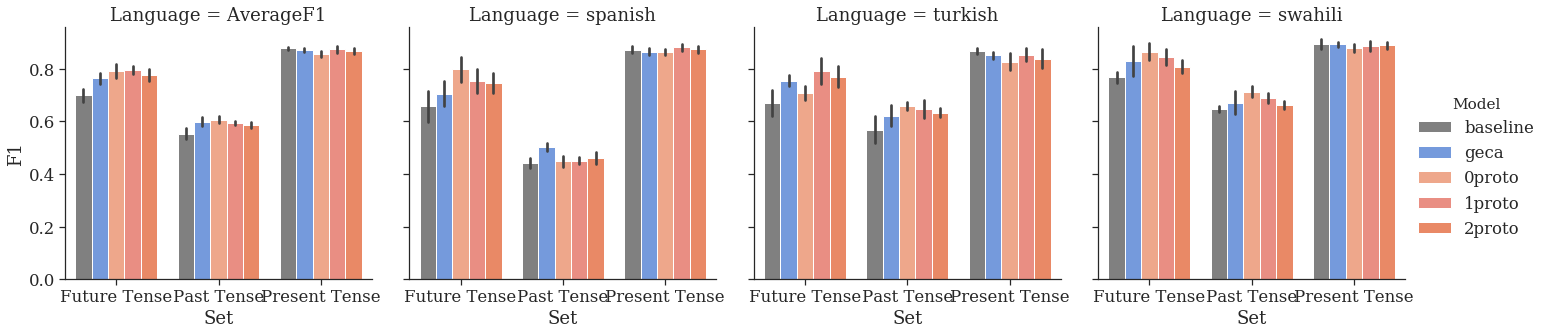

In [28]:
df_filtered_avg = get_morph_results_graph(df)

df_filtered_avg = df_filtered_avg.rename(columns={'Split':'Set'})

palette = {"baseline":"grey",
          "0proto":"lightsalmon",
          "1proto":"salmon",
          "2proto":"coral",
          "geca":"cornflowerblue"}

g = sns.catplot(x="Set",
               y=score,
               col="Language",
               hue="Model",
               col_order=["Average"+score, "spanish","turkish","swahili"],
               kind="bar",
               data=df_filtered_avg,
               hue_order=["baseline","geca","0proto","1proto","2proto"],
               ci='sd',
               palette=palette#sns.color_palette("RdBu", n_colors=5)
               )

# g = sns.relplot(x="Model", y=score, #units="Seed", 
#                 #estimator=None, 
#                 ci="sd",
#                 hue="Split", style="Split", col_order=["Average"+score, "spanish","turkish","swahili"],
#                 col="Language", kind="line", markers=True, data=df_filtered_avg, sort=True, err_style="bars").\
#             map(sns.lineplot, "Model", "F1", order=[3,0,1,2,4])

In [29]:
#fix labels and save
axes = g.axes.flatten()
axes[0].set_title("Average")
axes[0].set_ylim(0.25,)
axes[1].set_title("Spanish")
axes[2].set_title("Turkish")
axes[3].set_title("Swahili")
g.set_xticklabels(rotation=15)
g.savefig("morph_results_hints4_novae_{}.pdf".format(score), dpi=300, verbose=True)

#### Table

In [164]:
df

,Language,Hints,Seed,Vae,Model,Split,Acc,Acc_std,F1,F1_std
0,spanish,4,0,true,baseline,TEST EVALS,0.01,0.099499,0.595486,0.172985
1,spanish,4,0,true,baseline,VAL EVALS,0.03,0.170587,0.465753,0.201385
2,spanish,4,0,true,baseline,TEST EASY,0.64,0.480000,0.873440,0.191549
3,spanish,4,0,true,baseline,VAL EASY,0.61,0.487750,0.866667,0.201838
4,spanish,4,0,true,0proto,TEST EVALS,0.20,0.400000,0.719523,0.207692
...,...,...,...,...,...,...,...,...,...,...
1795,swahili,16,4,true,geca,VAL EASY,0.57,0.495076,0.893037,0.161466
1796,swahili,16,4,false,geca,TEST EVALS,0.04,0.195959,0.746372,0.127119
1797,swahili,16,4,false,geca,VAL EVALS,0.12,0.324962,0.707844,0.228641
1798,swahili,16,4,false,geca,TEST EASY,0.51,0.499900,0.882096,0.167574


In [365]:
def mean_std(x):
    return(str(round(np.mean(x),2))+" (${+-}"+str(round(np.std(x),2))+"$)")

In [333]:
def get_morph_results_table(df, hints=4, vae="false"):
    hints=4
    vae="false"
    splits_s = ["TEST EVALS", "VAL EVALS", "TEST EASY"]
    splits_s_alt = ["Future Tense", "Past Tense", "Present Tense"]
    score_s = ["Acc", "F1"]
    cols_s = ["Language", "Seed", "Model", "Split"] + score_s

    df_filtered_s = df.replace(splits_s, splits_s_alt).\
                    loc[(df['Split'].isin(splits_s)) & (df['Vae'] == vae) & (df['Hints'] == hints), cols_s].\
                    reset_index().\
                    drop(columns=['index'])

    print("Len: ", len(df_filtered_s))
    df_mean_std = df_filtered_s.groupby(by=["Model","Split", "Language"]).\
                    agg({"Acc":["mean","std"], "F1":["mean","std"]}).\
                    reset_index("Split").pivot(columns="Split")
    df_mean_std.columns = df_mean_std.columns.swaplevel(1,0)
    return(df_mean_std.iloc[:,[0,3,2,5,1,4]])


In [389]:
def get_morph_results_table_alt_std(df, hints=4, vae="false"):
    splits_s = ["TEST EVALS", "VAL EVALS", "TEST EASY"]
    splits_s_alt = ["Future Tense", "Past Tense", "Present Tense"]
    score_s = ["Acc", "F1"]
    cols_s = ["Language", "Seed", "Model", "Split"] + score_s

    df_filtered_s = df.replace(splits_s, splits_s_alt).\
                    loc[(df['Split'].isin(splits_s)) & (df['Vae'] == vae) & (df['Hints'] == hints), cols_s].\
                    reset_index().\
                    drop(columns=['index'])

    print("Len: ", len(df_filtered_s))
    df_mean_std = df_filtered_s.groupby(by=["Model","Split", "Seed"]).\
                    agg({"Acc":"mean", "F1":"mean"}).\
                    reset_index().\
                    groupby(by=["Model","Split"]).\
                    agg({'Acc':mean_std, 'F1':mean_std}).\
                    reset_index("Split").pivot(columns="Split")

    df_mean_std.columns = df_mean_std.columns.swaplevel(1,0)
    return(df_mean_std.iloc[:,[0,3,1,4,2,5]])

In [390]:
df_mean_std = get_morph_results_table_alt_std(df)
display(df_mean_std)
print(df_mean_std.to_latex())

Len:  450


Split          Future Tense                            Past Tense  \
                        Acc                 F1                Acc   
Model                                                               
0proto    0.36 (${+-}0.05$)  0.79 (${+-}0.03$)  0.06 (${+-}0.03$)   
1proto    0.31 (${+-}0.03$)   0.8 (${+-}0.01$)  0.05 (${+-}0.01$)   
2proto    0.19 (${+-}0.04$)  0.77 (${+-}0.02$)  0.03 (${+-}0.01$)   
baseline  0.13 (${+-}0.05$)   0.7 (${+-}0.03$)  0.03 (${+-}0.02$)   
geca       0.24 (${+-}0.1$)  0.76 (${+-}0.02$)  0.07 (${+-}0.03$)   

Split                            Present Tense                     
                         F1                Acc                 F1  
Model                                                              
0proto    0.61 (${+-}0.01$)  0.56 (${+-}0.03$)  0.85 (${+-}0.01$)  
1proto    0.59 (${+-}0.01$)  0.57 (${+-}0.04$)  0.87 (${+-}0.01$)  
2proto    0.59 (${+-}0.01$)  0.59 (${+-}0.03$)  0.87 (${+-}0.01$)  
baseline  0.55 (${+-}0.02$)   0.6 (${+-}0.03$)  0.88 (${+-}0.01$)  
geca       0.6 (${+-}0.02$)  0.58 (${+-}0.03$)  0.87 (${+-}0.01$)

\begin{tabular}{lllllll}
\toprule
Split & \multicolumn{2}{l}{Future Tense} & \multicolumn{2}{l}{Past Tense} & \multicolumn{2}{l}{Present Tense} \\
{} &                Acc &                 F1 &                Acc &                 F1 &                Acc &                 F1 \\
Model    &                    &                    &                    &                    &                    &                    \\
\midrule
0proto   &  0.36 (\$\{+-\}0.05\$) &  0.79 (\$\{+-\}0.03\$) &  0.06 (\$\{+-\}0.03\$) &  0.61 (\$\{+-\}0.01\$) &  0.56 (\$\{+-\}0.03\$) &  0.85 (\$\{+-\}0.01\$) \\
1proto   &  0.31 (\$\{+-\}0.03\$) &   0.8 (\$\{+-\}0.01\$) &  0.05 (\$\{+-\}0.01\$) &  0.59 (\$\{+-\}0.01\$) &  0.57 (\$\{+-\}0.04\$) &  0.87 (\$\{+-\}0.01\$) \\
2proto   &  0.19 (\$\{+-\}0.04\$) &  0.77 (\$\{+-\}0.02\$) &  0.03 (\$\{+-\}0.01\$) &  0.59 (\$\{+-\}0.01\$) &  0.59 (\$\{+-\}0.03\$) &  0.87 (\$\{+-\}0.01\$) \\
baseline &  0.13 (\$\{+-\}0.05\$) &   0.7 (\$\{+-\}0.03\$) &  0.03 (\$\{+-\}0.02\$) &  0

### SCAN Results Graph

In [15]:
def get_scan_scores(df=None,
                    tasks=("jump","around_right"),
                    seeds=(0,1,2,3,4),
                    vaes =("true","false"),
                    models=("0proto","1proto","2proto"),
                    exppath="/home/gridsan/eakyurek/git/protogen/checkpoints",
                   ):
    for task in tasks:
            for seed in seeds:
                for vae in vaes:
                    for model in  models:
                        taskpath=os.path.join(exppath,"SCANDataSet")
                        identifier ="{}.vae.{}.{}.seed.{}".format(model,vae,task,seed)
                        condfile=os.path.join(taskpath,"logs",identifier+".cond.log") 
                        if os.path.exists(condfile):
                            lines  = open(condfile,'r').readlines()
                            print("processing: "+condfile)
                            for (s,r) in get_splits(condfile).items():
                                acc, accstd, f1, f1std = calculate_scores(lines[r])  
                                df.loc[len(df.index)] = (task,s,seed,vae,model,acc,accstd,f1,f1std)
                        else:
                            print(f"file doesnot exist: {condfile}")

In [327]:
#create SCAN table
dfscan = pd.DataFrame(columns=("Task",'Split', 'Seed', 'Vae','Model','Acc','Acc_std','F1','F1_std',))
get_scan_scores(df=dfscan)
dfscan_other = pd.DataFrame(columns=("Task",'Split', 'Seed', 'Vae','Model','Acc','Acc_std','F1','F1_std',))
get_scan_scores(df=dfscan_other,
                models=("2proto",),
                tasks=("jump",),
                exppath="/home/gridsan/eakyurek/git/protogen/checkpoints_dgx_scan/",
               )
# results with seed 5-9
dfscan_other['Seed'] = dfscan_other['Seed'] + 5
dfscan_all=dfscan.append(dfscan_other, ignore_index=True)
dfscan_all

processing: /home/gridsan/eakyurek/git/protogen/checkpoints/SCANDataSet/logs/0proto.vae.true.jump.seed.0.cond.log
processing: /home/gridsan/eakyurek/git/protogen/checkpoints/SCANDataSet/logs/1proto.vae.true.jump.seed.0.cond.log
processing: /home/gridsan/eakyurek/git/protogen/checkpoints/SCANDataSet/logs/2proto.vae.true.jump.seed.0.cond.log
processing: /home/gridsan/eakyurek/git/protogen/checkpoints/SCANDataSet/logs/0proto.vae.false.jump.seed.0.cond.log
processing: /home/gridsan/eakyurek/git/protogen/checkpoints/SCANDataSet/logs/1proto.vae.false.jump.seed.0.cond.log
processing: /home/gridsan/eakyurek/git/protogen/checkpoints/SCANDataSet/logs/2proto.vae.false.jump.seed.0.cond.log
processing: /home/gridsan/eakyurek/git/protogen/checkpoints/SCANDataSet/logs/0proto.vae.true.jump.seed.1.cond.log
processing: /home/gridsan/eakyurek/git/protogen/checkpoints/SCANDataSet/logs/1proto.vae.true.jump.seed.1.cond.log
processing: /home/gridsan/eakyurek/git/protogen/checkpoints/SCANDataSet/logs/2proto.v

processing: /home/gridsan/eakyurek/git/protogen/checkpoints_dgx_scan/SCANDataSet/logs/2proto.vae.false.jump.seed.4.cond.log


,Task,Split,Seed,Vae,Model,Acc,Acc_std,F1,F1_std
0,jump,TEST EVALS,0,true,0proto,0.000000,0.000000,0.756223,0.154850
1,jump,VAL EVALS,0,true,0proto,0.998485,0.038895,1.000000,0.000000
2,jump,TEST EVALS,0,true,1proto,0.014794,0.120726,0.753597,0.159557
3,jump,VAL EVALS,0,true,1proto,1.000000,0.000000,1.000000,0.000000
4,jump,TEST EVALS,0,true,2proto,0.987412,0.111486,0.998560,0.045034
...,...,...,...,...,...,...,...,...,...
135,jump,VAL EVALS,8,false,2proto,0.986364,0.115976,1.000000,0.000000
136,jump,TEST EVALS,9,true,2proto,0.810797,0.391670,0.980174,0.053297
137,jump,VAL EVALS,9,true,2proto,1.000000,0.000000,1.000000,0.000000
138,jump,TEST EVALS,9,false,2proto,0.744355,0.436223,0.940522,0.119155


In [368]:
dfscan_all

,Task,Split,Seed,Vae,Model,Acc,Acc_std,F1,F1_std
0,jump,TEST EVALS,0,true,0proto,0.000000,0.000000,0.756223,0.154850
1,jump,VAL EVALS,0,true,0proto,0.998485,0.038895,1.000000,0.000000
2,jump,TEST EVALS,0,true,1proto,0.014794,0.120726,0.753597,0.159557
3,jump,VAL EVALS,0,true,1proto,1.000000,0.000000,1.000000,0.000000
4,jump,TEST EVALS,0,true,2proto,0.987412,0.111486,0.998560,0.045034
...,...,...,...,...,...,...,...,...,...
135,jump,VAL EVALS,8,false,2proto,0.986364,0.115976,1.000000,0.000000
136,jump,TEST EVALS,9,true,2proto,0.810797,0.391670,0.980174,0.053297
137,jump,VAL EVALS,9,true,2proto,1.000000,0.000000,1.000000,0.000000
138,jump,TEST EVALS,9,false,2proto,0.744355,0.436223,0.940522,0.119155


In [386]:
def get_scan_results_table(dfscan_all):
    splits_s = ["TEST EVALS"]
    score_s = "Acc"
    cols_s = ["Task", "Seed", "Model", "Split", score_s]
    vae_s = "false"
    
    df_filtered_s = dfscan_all.loc[(dfscan_all['Split'].isin(splits_s)) & (dfscan_all['Vae'] == vae_s), cols_s].\
                    reset_index().\
                    drop(columns=['index', 'Split'])
                    
    df_filtered_s.head()
    print("Len: ", len(df_filtered_s))
    
    # add geca and baseline scores
    geca_baseline_s = pd.read_csv("scan-geca-baseline.csv", header=None)
    print("Total of {} GECA and baseline records.".format(len(geca_baseline_s)))
    
    # append
    for index,row in geca_baseline_s.iterrows():
    
        task = row[0]
        seed = row[1]
        model = row[2]
        val = float(row[3])

        df_filtered_s.loc[len(df_filtered_s)] = [task, seed, model, val]
    
    dfscan_mean_std = df_filtered_s.groupby(by=["Model","Task"]).\
                    agg({"Acc":mean_std}).\
                    reset_index("Task").\
                    pivot(columns="Task").\
                    rename(columns={"around_right":"AROUND RIGHT", "jump":"JUMP"})

    return(dfscan_mean_std)



In [387]:
dfscan_mean_std = get_scan_results_table(dfscan_all)
dfscan_mean_std

Len:  35
Total of 39 GECA and baseline records.


Acc                   
Task            AROUND RIGHT               JUMP
Model                                          
 baseline    0.0 (${+-}0.0$)    0.0 (${+-}0.0$)
 geca      0.82 (${+-}0.11$)  0.87 (${+-}0.05$)
0proto       0.0 (${+-}0.0$)    0.0 (${+-}0.0$)
1proto     0.16 (${+-}0.04$)    0.0 (${+-}0.0$)
2proto     0.51 (${+-}0.07$)  0.88 (${+-}0.08$)

In [388]:
print(dfscan_mean_std.to_latex())

\begin{tabular}{lll}
\toprule
{} & \multicolumn{2}{l}{Acc} \\
Task &       AROUND RIGHT &               JUMP \\
Model     &                    &                    \\
\midrule
 baseline &    0.0 (\$\{+-\}0.0\$) &    0.0 (\$\{+-\}0.0\$) \\
 geca     &  0.82 (\$\{+-\}0.11\$) &  0.87 (\$\{+-\}0.05\$) \\
0proto    &    0.0 (\$\{+-\}0.0\$) &    0.0 (\$\{+-\}0.0\$) \\
1proto    &  0.16 (\$\{+-\}0.04\$) &    0.0 (\$\{+-\}0.0\$) \\
2proto    &  0.51 (\$\{+-\}0.07\$) &  0.88 (\$\{+-\}0.08\$) \\
\bottomrule
\end{tabular}



In [10]:
def get_lang_scores_unreduced(df=None,
                    langs=("spanish","turkish","swahili"),
                    hintss=(4,8,16),
                    seeds=(0,1,2,3,4),
                    vaes =("true","false"),
                    models=("baseline","0proto","1proto","2proto"),
                    exppath="/home/gridsan/eakyurek/git/protogen/checkpoints",
                   ):
    for lang in langs:
        for hints in hintss:
            for seed in seeds:
                for vae in vaes:
                    for model in  models:
                        langpath=os.path.join(exppath,"SIGDataSet",lang)
                        if model == "baseline" or model == "geca":
                            identifier ="{}.hints.{}.seed.{}".format(model,hints,seed)
                        else:
                            identifier ="{}.vae.{}.hints.{}.seed.{}".format(model,vae,hints,seed)
                        condfile=os.path.join(langpath,"logs",identifier+".cond.log") 
                        if os.path.exists(condfile):
                            lines  = open(condfile,'r').readlines()
                            if len(lines) < 2142:
                                print("format broken in "+condfile)
                                continue
#                             print("processing: "+condfile)
                            for (s,r) in get_splits(condfile).items():#splitinfo.items():
                                acc, accstd, f1, f1std = calculate_scores_unreduced(lines[r])  
                                df.loc[len(df.index)] = (lang,hints,seed,vae,model,s,acc,accstd,f1,f1std)
                        else:
                            print(f"file doesnot exist: {condfile}")

In [11]:
dfunreduced = pd.DataFrame(columns=('Language', 'Hints', 'Seed', 'Vae','Model','Split','Acc','Acc_std','F1','F1_std',))
get_lang_scores_unreduced(df=dfunreduced,exppath="/home/gridsan/eakyurek/git/protogen/checkpoints")
get_lang_scores_unreduced(df=dfunreduced,exppath="/home/gridsan/eakyurek/git/gecaexp/checkpoints",
                models=("geca",))
dfunreduced

,Language,Hints,Seed,Vae,Model,Split,Acc,Acc_std,F1,F1_std
0,spanish,4,0,true,baseline,TEST EVALS,0.01,"[False, False, False, False, False, False, Fal...",0.595486,"[0.8333333333333334, 0.7272727272727272, 0.333..."
1,spanish,4,0,true,baseline,VAL EVALS,0.03,"[False, False, False, False, False, False, Fal...",0.465753,"[0.4615384615384615, 0.30769230769230765, 0.83..."
2,spanish,4,0,true,baseline,TEST EASY,0.64,"[False, False, True, False, True, False, False...",0.873440,"[0.8333333333333334, 0.8333333333333334, 1.0, ..."
3,spanish,4,0,true,baseline,VAL EASY,0.61,"[False, True, False, False, True, False, True,...",0.866667,"[0.8333333333333334, 1.0, 0.3333333333333333, ..."
4,spanish,4,0,true,0proto,TEST EVALS,0.20,"[False, False, False, False, False, False, Fal...",0.719523,"[0.6666666666666666, 0.8333333333333334, 0.833..."
...,...,...,...,...,...,...,...,...,...,...
1795,swahili,16,4,true,geca,VAL EASY,0.57,"[True, False, False, True, True, False, True, ...",0.893037,"[1.0, 0.75, 0.6153846153846153, 1.0, 1.0, 0.70..."
1796,swahili,16,4,false,geca,TEST EVALS,0.04,"[False, False, False, False, False, False, Fal...",0.746372,"[0.7142857142857143, 0.8571428571428571, 0.666..."
1797,swahili,16,4,false,geca,VAL EVALS,0.12,"[True, True, False, False, False, False, True,...",0.707844,"[1.0, 1.0, 0.6250000000000001, 0.8888888888888..."
1798,swahili,16,4,false,geca,TEST EASY,0.51,"[True, True, False, False, True, False, False,...",0.882096,"[1.0, 1.0, 0.875, 0.875, 1.0, 0.83333333333333..."


In [381]:
dfunreduced.head()

,Language,Hints,Seed,Vae,Model,Split,Acc,Acc_std,F1,F1_std
0,spanish,4,0,true,baseline,TEST EVALS,0.01,"[False, False, False, False, False, False, Fal...",0.595486,"[0.8333333333333334, 0.7272727272727272, 0.333..."
1,spanish,4,0,true,baseline,VAL EVALS,0.03,"[False, False, False, False, False, False, Fal...",0.465753,"[0.4615384615384615, 0.30769230769230765, 0.83..."
2,spanish,4,0,true,baseline,TEST EASY,0.64,"[False, False, True, False, True, False, False...",0.873440,"[0.8333333333333334, 0.8333333333333334, 1.0, ..."
3,spanish,4,0,true,baseline,VAL EASY,0.61,"[False, True, False, False, True, False, True,...",0.866667,"[0.8333333333333334, 1.0, 0.3333333333333333, ..."
4,spanish,4,0,true,0proto,TEST EVALS,0.20,"[False, False, False, False, False, False, Fal...",0.719523,"[0.6666666666666666, 0.8333333333333334, 0.833..."


In [396]:
l=[]
l.extend([3])

In [ ]:
l

In [29]:
import pdb

In [95]:
d = {}
models=("baseline","geca","0proto","1proto","2proto")
langs = ("spanish", "turkish", "swahili")
hints=4
vae="false"
split="TEST EVALS"
cols = ["Language", "Seed", "Model", "Acc_std", "F1_std"]
conds = (dfunreduced["Hints"]==hints) & (dfunreduced['Vae']==vae) & (dfunreduced["Split"]==split)
dfunreduced_filtered = dfunreduced.loc[conds, cols]


In [96]:
dfunreduced_filtered

,Language,Seed,Model,Acc_std,F1_std
16,spanish,0,baseline,"[False, False, False, False, False, False, Fal...","[0.8333333333333334, 0.7272727272727272, 0.333..."
20,spanish,0,0proto,"[True, False, False, False, False, True, True,...","[1.0, 0.8333333333333334, 0.5, 0.5, 0.66666666..."
24,spanish,0,1proto,"[False, False, False, False, False, False, Tru...","[0.4615384615384615, 0.8333333333333334, 0.833..."
28,spanish,0,2proto,"[False, False, True, False, False, False, Fals...","[0.4615384615384615, 0.6153846153846153, 1.0, ..."
48,spanish,1,baseline,"[False, False, False, False, False, False, Fal...","[0.5, 0.3333333333333333, 0.8333333333333334, ..."
...,...,...,...,...,...
1684,swahili,0,geca,"[False, False, False, False, False, True, Fals...","[0.7142857142857143, 0.8571428571428571, 0.714..."
1692,swahili,1,geca,"[True, True, True, False, False, True, True, T...","[1.0, 1.0, 1.0, 0.7142857142857143, 0.66666666..."
1700,swahili,2,geca,"[False, True, True, False, True, False, True, ...","[0.6666666666666666, 1.0, 1.0, 0.8571428571428..."
1708,swahili,3,geca,"[False, False, False, False, True, True, False...","[0.7692307692307692, 0.8571428571428571, 0.666..."


In [97]:
for m in models:
    d[m] = {}
    for t in ["Acc_std", "F1_std"]:
        d[m][t] = []
        for l in langs:
            for s in range(5):
                cond1 = (dfunreduced_filtered["Model"]==m) & (dfunreduced_filtered["Language"]==l)
                cond2 = (dfunreduced_filtered["Seed"]==s)
#                 pdb.set_trace()
                if t == "Acc_std":
                    d[m][t].extend([int(el) for el in dfunreduced_filtered.loc[cond1 & cond2, t].tolist()[0]])
                else:
                    d[m][t].extend(dfunreduced_filtered.loc[cond1 & cond2, t].tolist()[0])
#         d[m][t].update({t:ls})

In [66]:
len(d["baseline"]["Acc_std"])

1500

In [67]:
sum(d["baseline"]["Acc_std"])

200

In [68]:
sum(d["0proto"]["Acc_std"])

539

In [98]:
d_avg = {}
for m in models:
    d_avg[m] = {}
    for t in ["Acc_std", "F1_std"]:
#         d_avg[m][t] = {}
        d_avg[m][t] = np.mean(d[m][t])
#         d_avg[m][t]["std"] = np.std(d[m][t])

In [99]:
pd.DataFrame(d_avg)

,baseline,geca,0proto,1proto,2proto
Acc_std,0.133333,0.243333,0.359333,0.311333,0.192667
F1_std,0.692341,0.758732,0.780631,0.792064,0.771988


In [35]:
from scipy import stats

In [101]:
def t_test(model1, model2, t):
    return(stats.ttest_rel(d[model1][t],d[model2][t]).pvalue)

def get_pvals(t):
    sign = {}
    for m1 in models:
        sign[m1] = {}
        for m2 in models:
            sign[m1][m2] = t_test(m1,m2,t)
    return(pd.DataFrame(sign))
print("acc")       
display(get_pvals("Acc_std"))
print("f1")
display(get_pvals("F1_std"))

acc


,baseline,geca,0proto,1proto,2proto
baseline,NaN,1.550081e-15,1.600765e-48,3.591011e-32,7.481700e-06
geca,1.550081e-15,NaN,4.923557e-12,2.249231e-05,6.483285e-04
0proto,1.600765e-48,4.923557e-12,NaN,5.167716e-03,3.006737e-24
1proto,3.591011e-32,2.249231e-05,5.167716e-03,NaN,6.600711e-14
2proto,7.481700e-06,6.483285e-04,3.006737e-24,6.600711e-14,NaN


f1


,baseline,geca,0proto,1proto,2proto
baseline,NaN,7.566961e-16,1.506069e-21,3.785714e-32,2.232144e-23
geca,7.566961e-16,NaN,1.315362e-02,1.876577e-05,7.638536e-02
0proto,1.506069e-21,1.315362e-02,NaN,1.893049e-01,2.970492e-01
1proto,3.785714e-32,1.876577e-05,1.893049e-01,NaN,6.946424e-03
2proto,2.232144e-23,7.638536e-02,2.970492e-01,6.946424e-03,NaN


In [84]:
a = t_test("1proto", "0proto", "Acc_std")
# t_test("1proto", "0proto", "Acc_std")

In [85]:
a

0.005167716432681802

In [ ]:
def my_extend(x):
    l = []
#     pdb.set_trace()
    for el in x:
        l.extend(ell)
    return(l)

def t_test(model1, model2, hints=4, vae="false"):
    d = dfunreduced.loc[(dfunreduced["Hints"]==hints) & (dfunreduced['Vae']==vae)]. \
            groupby(by="Model").agg({"Acc_std":my_extend, "F1_std":my_extend}). \
            loc[:,["Model","Acc_std","F1_std"]]
    return d

t_test("baseline","0proto")


    

In [403]:
hints=4
vae="false"
dfunreduced.loc[(dfunreduced["Hints"]==hints) & (dfunreduced['Vae']==vae)]. \
            groupby(by="Model").agg({"Acc_std":my_extend, "F1_std":my_extend})

,Acc_std,F1_std
Model,,
0proto,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
1proto,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
2proto,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
baseline,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
geca,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."


In [408]:
dfunreduced.loc[(dfunreduced["Hints"]==hints) & (dfunreduced['Vae']==vae)]

,Language,Hints,Seed,Vae,Model,Split,Acc,Acc_std,F1,F1_std
16,spanish,4,0,false,baseline,TEST EVALS,0.01,"[False, False, False, False, False, False, Fal...",0.595486,"[0.8333333333333334, 0.7272727272727272, 0.333..."
17,spanish,4,0,false,baseline,VAL EVALS,0.03,"[False, False, False, False, False, False, Fal...",0.465753,"[0.4615384615384615, 0.30769230769230765, 0.83..."
18,spanish,4,0,false,baseline,TEST EASY,0.64,"[False, False, True, False, True, False, False...",0.873440,"[0.8333333333333334, 0.8333333333333334, 1.0, ..."
19,spanish,4,0,false,baseline,VAL EASY,0.61,"[False, True, False, False, True, False, True,...",0.866667,"[0.8333333333333334, 1.0, 0.3333333333333333, ..."
20,spanish,4,0,false,0proto,TEST EVALS,0.40,"[True, False, False, False, False, True, True,...",0.751286,"[1.0, 0.8333333333333334, 0.5, 0.5, 0.66666666..."
...,...,...,...,...,...,...,...,...,...,...
1711,swahili,4,3,false,geca,VAL EASY,0.49,"[False, True, True, True, False, False, True, ...",0.844840,"[0.75, 1.0, 1.0, 1.0, 0.6153846153846153, 0.85..."
1716,swahili,4,4,false,geca,TEST EVALS,0.18,"[False, False, False, False, False, True, Fals...",0.773611,"[0.8571428571428571, 0.8571428571428571, 0.666..."
1717,swahili,4,4,false,geca,VAL EVALS,0.00,"[False, False, False, False, False, False, Fal...",0.650155,"[0.7058823529411765, 0.7058823529411765, 0.875..."
1718,swahili,4,4,false,geca,TEST EASY,0.61,"[True, True, True, True, False, True, True, Tr...",0.897101,"[1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0,..."


In [407]:
dfunreduced.loc[(dfunreduced["Hints"]==hints) & (dfunreduced['Vae']==vae)]. \
            groupby(by="Model")

In [ ]:
def get_scan_scores_unreduced(df=None,
                    tasks=("jump","around_right"),
                    seeds=(0,1,2,3,4),
                    vaes =("true","false"),
                    models=("0proto","1proto","2proto"),
                    exppath="/home/gridsan/eakyurek/git/protogen/checkpoints",
                   ):
    for task in tasks:
            for seed in seeds:
                for vae in vaes:
                    for model in  models:
                        taskpath=os.path.join(exppath,"SCANDataSet")
                        identifier ="{}.vae.{}.{}.seed.{}".format(model,vae,task,seed)
                        condfile=os.path.join(taskpath,"logs",identifier+".cond.log") 
                        if os.path.exists(condfile):
                            lines  = open(condfile,'r').readlines()
                            print("processing: "+condfile)
                            for (s,r) in get_splits(condfile).items():
                                acc, accstd, f1, f1std = calculate_scores_unreduced(lines[r])  
                                df.loc[len(df.index)] = (task,s,seed,vae,model,acc,accstd,f1,f1std)
                        else:
                            print(f"file doesnot exist: {condfile}")

#### Ablations

In [409]:
dfscan_ablations[(dfscan_ablations["Split"]=="TEST EVALS") & (dfscan_ablations["Task"]=="around_right")].

,Task,Split,Seed,Vae,Model,Acc,Acc_std,F1,F1_std
12,around_right,TEST EVALS,0,true,ID.1proto,0.125559,0.331351,0.992651,0.038756
14,around_right,TEST EVALS,0,true,nocopy.1proto,0.000000,0.000000,0.929009,0.087060
16,around_right,TEST EVALS,0,false,nocopy.1proto,0.033289,0.179389,0.928920,0.086338
18,around_right,TEST EVALS,0,false,nocopy.2proto,0.000000,0.000000,0.889319,0.121090
20,around_right,TEST EVALS,1,true,ID.1proto,0.152368,0.359377,0.984043,0.047892
22,around_right,TEST EVALS,1,true,nocopy.1proto,0.012288,0.110167,0.940403,0.091401
24,around_right,TEST EVALS,1,false,nocopy.1proto,0.000000,0.000000,0.920174,0.095518
26,around_right,TEST EVALS,1,false,nocopy.2proto,0.348972,0.476645,0.996311,0.018516
28,around_right,TEST EVALS,2,true,ID.1proto,0.129133,0.335347,0.983158,0.048515
30,around_right,TEST EVALS,2,true,nocopy.1proto,0.000000,0.000000,0.928197,0.091061


In [377]:
dfscan_ablations = pd.DataFrame(columns=("Task",'Split', 'Seed', 'Vae','Model','Acc','Acc_std','F1','F1_std',))
get_scan_scores(df=dfscan_ablations,
                models=("ID.1proto","nocopy.1proto", "nocopy.2proto"),
                exppath="/home/gridsan/eakyurek/git/ablations/checkpoints/",
               )

processing: /home/gridsan/eakyurek/git/ablations/checkpoints/SCANDataSet/logs/ID.1proto.vae.true.jump.seed.0.cond.log
file doesnot exist: /home/gridsan/eakyurek/git/ablations/checkpoints/SCANDataSet/logs/nocopy.1proto.vae.true.jump.seed.0.cond.log
file doesnot exist: /home/gridsan/eakyurek/git/ablations/checkpoints/SCANDataSet/logs/nocopy.2proto.vae.true.jump.seed.0.cond.log
file doesnot exist: /home/gridsan/eakyurek/git/ablations/checkpoints/SCANDataSet/logs/ID.1proto.vae.false.jump.seed.0.cond.log
processing: /home/gridsan/eakyurek/git/ablations/checkpoints/SCANDataSet/logs/nocopy.1proto.vae.false.jump.seed.0.cond.log
processing: /home/gridsan/eakyurek/git/ablations/checkpoints/SCANDataSet/logs/nocopy.2proto.vae.false.jump.seed.0.cond.log
processing: /home/gridsan/eakyurek/git/ablations/checkpoints/SCANDataSet/logs/ID.1proto.vae.true.jump.seed.1.cond.log
file doesnot exist: /home/gridsan/eakyurek/git/ablations/checkpoints/SCANDataSet/logs/nocopy.1proto.vae.true.jump.seed.1.cond.log
f

In [407]:
dfscan_ablations[(dfscan_ablations["Split"]=="TEST EVALS") & (dfscan_ablations["Task"]=="around_right")]

,Task,Split,Seed,Vae,Model,Acc,Acc_std,F1,F1_std
12,around_right,TEST EVALS,0,true,ID.1proto,0.125559,0.331351,0.992651,0.038756
14,around_right,TEST EVALS,0,true,nocopy.1proto,0.000000,0.000000,0.929009,0.087060
16,around_right,TEST EVALS,0,false,nocopy.1proto,0.033289,0.179389,0.928920,0.086338
18,around_right,TEST EVALS,0,false,nocopy.2proto,0.000000,0.000000,0.889319,0.121090
20,around_right,TEST EVALS,1,true,ID.1proto,0.152368,0.359377,0.984043,0.047892
22,around_right,TEST EVALS,1,true,nocopy.1proto,0.012288,0.110167,0.940403,0.091401
24,around_right,TEST EVALS,1,false,nocopy.1proto,0.000000,0.000000,0.920174,0.095518
26,around_right,TEST EVALS,1,false,nocopy.2proto,0.348972,0.476645,0.996311,0.018516
28,around_right,TEST EVALS,2,true,ID.1proto,0.129133,0.335347,0.983158,0.048515
30,around_right,TEST EVALS,2,true,nocopy.1proto,0.000000,0.000000,0.928197,0.091061


In [ ]:
!scp supercloud:~/git/protogen/results.txt ./results.txt

In [ ]:
!scp supercloud:~/git/gecaexp/results.txt ./results.txt

In [ ]:
with open('results.txt') as file:
    lines = [line.rstrip('\n') for line in file]

In [ ]:
langs = ["spanish", "turkish","swahili"]
latex_langs = [l.upper() for l in langs]
d_langs = dict(zip(langs, latex_langs))

#models = ["baseline", "0proto", "1proto", "2proto"]
models  = ["2proto"]
latex_models = ["s2s","s2s + 0-proto","s2s + 1-proto","s2s+ 2-proto"]
d_models = dict(zip(models, latex_models))

In [ ]:
def get_table_1(score, hints, vae, setname, rnd=2):
    """
    set is val
    score in ["acc", "f1"]
    hints in [4,8,16]
    vae in [vae, novae]
    setname in ["test", "val"]
    """
    vae_var = "vae.true" if vae=="vae" else "vae.false"
    col_names = ["MODEL", "LANGUAGE", "EASINESS","RESULT"]
    df = pd.DataFrame(columns=col_names)
    easiness = ["acc", "acc_easy"] if score=="acc" else ["f1", "f1_easy"]
    for m in models:
        for e in easiness:
            total, std = 0.0, 0.0
            cnt   = 0
            for l in langs:
                sep = '.'
                search_line = sep.join([l,m,vae_var,"hints",str(hints),e])+':'
                if m == "baseline":
                    search_line = sep.join([l,m,"hints",str(hints),e])+':'
                matching = [i for i in lines if i.startswith(search_line)]
                if len(matching) > 1:
                    print(matching)
                    raise ValueError("More than 1 matching result.")
                if len(matching) == 0:
                    warnings.warn("Exp: {} missing.".format(search_line))
                    continue
                match = matching[0]
                temp = match.split("TEST",1)[1].split()
                test_ = float(temp[0].strip(':'))
                test_std = float(temp[2].strip(')'))
                val_ = float(temp[4])
                val_std = float(temp[6].strip(')'))

                result = val_ if setname=="val" else test_
                result_std = val_std if setname=="val" else test_std
                result_str = str(round(100*result,rnd)) + '$({+-}' + str(round(100*result_std,rnd)) + '$)'
                total += result
                std   += result_std
                cnt   += 1
                df.loc[len(df)] = [d_models[m], d_langs[l], e, result_str]
            result = total/cnt
            result_std = std/cnt
            result_str = str(round(100*result,rnd)) + ' $({+-}' + str(round(100*result_std,rnd)) + '$)'
            df.loc[len(df)] = [d_models[m], "U_AVG", e, result_str]
            
                
        
    piv = df.pivot_table(index='MODEL', columns=['LANGUAGE','EASINESS'], values='RESULT', aggfunc=lambda x: x)
  #  piv = df.pivot(index='MODEL', columns=['LANGUAGE','EASINESS'], values='RESULT')
    caps = "{} set {} results with {} hints and {}.".format(setname.upper(), score.upper(), hints, vae.upper())
    return(piv, caps)

In [ ]:
options = {'score':"acc" ,'hints':4, 'vae':'vae', 'setname':'test', 'rnd':1}
piv, caption = get_table_1(**options)
display(piv)
print(piv.to_latex(caption=caption))

In [ ]:
scan_splits = ["jump", "around_right"]
latex_scan_splits = [l.upper() for l in scan_splits]
d_scan_splits = dict(zip(scan_splits, latex_scan_splits))

def get_table_scan(score, vae, rnd=2):
    """
    set is val
    score in ["acc", "f1"]
    hints in [4,8,16]
    vae in [vae, novae]
    setname in ["test", "val"]
    """
    vae_var = "vae.true" if vae=="vae" else "vae.false"
    col_names = ["MODEL", "SPLIT", "SETNAME","RESULT"]
    df = pd.DataFrame(columns=col_names)
    #easiness = ["acc", "acc_easy"] if score=="acc" else ["f1", "f1_easy"]
    setname = ["test", "val"]
#     splits  = ["jump","around_right"]
    
    for m in models:
        total_val, std_val = 0.0, 0.0
        total_test, std_test = 0.0, 0.0
        cnt   = 0
        for l in scan_splits:
            sep = '.'
            search_line = sep.join([l,m,vae_var,score])+':'
            if m == "baseline":
                search_line = sep.join([l,m,score])+':'
            matching = [i for i in lines if i.startswith(search_line)]
            if len(matching) > 1:
                print(matching)
                raise ValueError("More than 1 matching result.")
            if len(matching) == 0:
                warnings.warn("Exp: {} missing.".format(search_line))
                continue
            match = matching[0]
            temp = match.split("TEST",1)[1].split()
            test_ = float(temp[0].strip(':'))
            test_std = float(temp[2].strip(')'))
            val_ = float(temp[4])
            val_std = float(temp[6].strip(')'))

            # val
            val_str = str(round(val_,rnd)) + ' {+-}' + str(round(val_std,rnd)) 
#             total_val += val_
#             std_val   += val_std
            
            # test
            test_str = str(round(test_,rnd)) + ' {+-}' + str(round(test_std,rnd))
#             total_test += test_
#             std_test   += test_std
            
#             cnt   += 1
            
#            df.loc[len(df)] = [d_models[m], d_scan_splits[l], "VAL", val_str]
            df.loc[len(df)] = [d_models[m], d_scan_splits[l], "TEST", test_str]
            
            
#             result = total/cnt
#             result_std = std/cnt
#             result_str = str(round(100*result,rnd)) + ' ({+-}' + str(round(100*result_std,rnd)) + ')'
#             df.loc[len(df)] = [d_models[m], "AVG", e, result_str]
                
        
    piv = df.pivot_table(index='MODEL', columns=['SPLIT','SETNAME'], values='RESULT', aggfunc=lambda x: x)
  #  piv = df.pivot(index='MODEL', columns=['LANGUAGE','EASINESS'], values='RESULT')
    caps = "SCAN {} results with {}.".format(score.upper(), vae.upper())
    return(piv, caps)

In [ ]:
options = {'score':"acc" , 'vae':'novae'}
piv, caption = get_table_scan(**options)
display(piv)
print(piv.to_latex(caption=caption))

In [ ]:
options = {'score':"acc" , 'vae':'vae'}
piv, caption = get_table_scan(**options)
display(piv)
print(piv.to_latex(caption=caption))

In [ ]:
def get_table_2(lang, score, vae, setname, rnd=2):
    """
    lang in ["spanish","turkish"]
    score in ["acc", "f1"]
    vae in [VAE, NOVAE]
    setname in ["test", "val"]
    """
    vae_var = "vae.true" if vae=="vae" else "vae.false"
    col_names = ["MODEL", "HINTS", "RESULT"]
    df = pd.DataFrame(columns=col_names)
    l = lang
    
    for m in models:
        for hints in [4,8,16]:
            sep = '.'
            search_line = sep.join([l,m,vae_var,"hints",str(hints),score])+':'
            if m == "baseline":
                search_line = sep.join([l,m,"hints",str(hints),score])+':'
            matching = [i for i in lines if i.startswith(search_line)]
            if len(matching) > 1:
                print(matching)
                raise ValueError("More than 1 matching result.")
            if len(matching) == 0:
                warnings.warn("Exp: {} missing.".format(search_line))
                continue
            match = matching[0]
            temp = match.split("TEST",1)[1].split()
            test_ = float(temp[0].strip(':'))
            test_std = float(temp[2].strip(')'))
            val_ = float(temp[4])
            val_std = float(temp[6].strip(')'))

            result = val_ if setname=="val" else test_
            result_std = val_std if setname=="val" else test_std
            result_str = str(round(100*result,rnd)) + ' ({+-}' + str(round(100*result_std,rnd)) + ')'
            df.loc[len(df)] = [d_models[m], hints, result_str]
            
    piv = df.pivot(index='MODEL', columns='HINTS', values='RESULT')
    caps = "{} {} set {} results with {}.".format(l.upper(), setname.upper(), score.upper(), vae.upper())
    return(piv, caps)

In [ ]:
options = {'lang':"spanish" , 'score':"acc", 'vae':'vae', 'setname':'test'}
piv, caption = get_table_2(**options)
display(piv)
print(caption)

In [ ]:
def get_table_3(lang, score, setname, hints, rnd=2):
    """
    lang in ["spanish","turkish"]
    score in ["acc", "f1"]
    setname in ["test", "val"]
    """
    vaes = ["VAE", "NOVAE"]
    
    col_names = ["MODEL", "VAE-STATUS", "RESULT"]
    df = pd.DataFrame(columns=col_names)
    l = lang
    
    for m in models:
        for vae in vaes:
            vae_var = "vae.true" if vae=="VAE" else "vae.false"
            sep = '.'
            search_line = sep.join([l, m, vae_var, "hints", str(hints), score])+':'
            if m == "baseline":
                search_line = sep.join([l,m,"hints",str(hints),score])+':'
            matching = [i for i in lines if i.startswith(search_line)]
            if len(matching) > 1:
                print(matching)
                raise ValueError("More than 1 matching result.")
            if len(matching) == 0:
                warnings.warn("Exp: {} missing.".format(search_line))
                continue
            match = matching[0]
            temp = match.split("TEST",1)[1].split()
            test_ = float(temp[0].strip(':'))
            test_std = float(temp[2].strip(')'))
            val_ = float(temp[4])
            val_std = float(temp[6].strip(')'))

            result = val_ if setname=="val" else test_
            result_std = val_std if setname=="val" else test_std
            result_str = str(round(100*result,rnd)) + ' ({+-}' + str(round(100*result_std,rnd)) + ')'
            df.loc[len(df)] = [d_models[m], vae, result_str]
            
    piv = df.pivot(index='MODEL', columns='VAE-STATUS', values='RESULT')
    caps = "{} {} set {} results with {} hints.".format(l.upper(), setname.upper(), score.upper(), hints)
    return(piv, caps)

In [ ]:
options = {'lang':"spanish" , 'score':"acc", 'setname':'test', 'hints':8}
piv, caption = get_table_3(**options)
display(piv)
print(caption)

In [ ]:
def get_table_4(lang, score, setname, hints, vae, rnd=2):
    """
    lang in ["spanish","turkish"]
    score in ["acc", "f1"]
    setname in ["test", "val"]
    """
    easiness = ["acc", "acc_easy"] if score=="acc" else ["f1", "f1_easy"]
    vae_var = "vae.true" if vae=="vae" else "vae.false"
    col_names = ["MODEL", "EASY-HARD", "RESULT"]
    df = pd.DataFrame(columns=col_names)
    l = lang
    
    for m in models:
        for score_var in easiness:
            sep = '.'
            search_line = sep.join([l, m, vae_var, "hints", str(hints), score_var])+':'
            if m == "baseline":
                search_line = sep.join([l,m,"hints",str(hints), score_var])+':'
            matching = [i for i in lines if i.startswith(search_line)]
            if len(matching) > 1:
                print(matching)
                raise ValueError("More than 1 matching result.")
            if len(matching) == 0:
                warnings.warn("Exp: {} missing.".format(search_line))
                continue
            match = matching[0]
            temp = match.split("TEST",1)[1].split()
            test_ = float(temp[0].strip(':'))
            test_std = float(temp[2].strip(')'))
            val_ = float(temp[4])
            val_std = float(temp[6].strip(')'))

            result = val_ if setname=="val" else test_
            result_std = val_std if setname=="val" else test_std
            result_str = str(round(100*result,rnd)) + ' ({+-}' + str(round(100*result_std,rnd)) + ')'
            df.loc[len(df)] = [d_models[m], score_var.upper(), result_str]
            
    piv = df.pivot(index='MODEL', columns='EASY-HARD', values='RESULT')
    caps = "{} {} set {} results with {} hints and {}.".format(l.upper(), setname.upper(), 
                                                               score.upper(), hints, vae.upper())
    return(piv, caps)

In [ ]:
options = {'lang':"spanish" , 'score':"acc", 'setname':'test', 'hints':4, 'vae':"novae"}
piv, caption = get_table_4(**options)
display(piv)
print(piv.to_latex(caption=caption))
print(caption)

In [ ]:
def get_table_morph(hints, easy_s, eval_set, rnd=2,):
    
    val = True if eval_set == "val" else False
    easy = True if easy_s == "easy" else False
    
    models = ["baseline", "0proto", "1proto", "2proto"]
    latex_models = ["Seq2Seq","Seq2Seq + 0-proto","Seq2Seq + 1-proto","Seq2Seq + 2-proto"]
    d_models = dict(zip(models, latex_models))
    
    langs = ["turkish", "spanish"]
    latex_langs = ["TURKISH", "SPANISH"]
    
    
    vae = ["vae.true", "vae.false"]
    latex_vae = ["VAE", "NOVAE"]
    d_vae = dict(zip(vae, latex_vae))
    
    score = ["acc_easy" if easy else "acc", "f1_easy" if easy else "f1"]
    latex_score = ["ACCEASY" if easy else "ACC", "F1_EASY" if easy else "F1"]
    d_score = dict(zip(score, latex_score))
    
    
    
    # create df
    col_names = ["model", "lang", "vae", "score", "result"]
    df = pd.DataFrame(columns=col_names)
    
    for m in models:
        for l in langs:
            for v in vae:
                for s in score:
                    sep = '.'
                    search_line = sep.join([l,m,v,"hints",str(hints),s])+':'
                    if m == "baseline":
                        search_line = sep.join([l,m,"hints",str(hints),s])+':'
                    matching = [i for i in lines if i.startswith(search_line)]
                    if len(matching) > 1:
                        print(matching)
                        raise ValueError("More than 1 matching result.")
                    if len(matching) == 0:
                        warnings.warn("Exp: {} missing.".format(search_line))
                        continue
                    match = matching[0]
                    temp = match.split("TEST",1)[1].split()
                    test_ = float(temp[0].strip(':'))
                    test_std = float(temp[2].strip(')'))
                    val_ = float(temp[4])
                    val_std = float(temp[6].strip(')'))
                    
                    result = val_ if val else test_
                    result_std = val_std if val else test_std
                    result_str = str(round(100*result,rnd)) + ' ({+-}' + str(round(100*result_std,rnd)) + ')'
                    df.loc[len(df)] = [d_models[m],d_langs[l],d_vae[v],d_score[s], result_str]
                
    piv = df.pivot_table(index='model', columns=['lang','vae','score'], values='result', aggfunc=lambda x: x)
    caps = eval_set.upper() + " set, " + easy_s.upper() + " scores for " + str(hints) + " hints."
    return(piv, caps)
                        

In [ ]:
def get_table_scan(eval_set, rnd=2):
    
    val = True if eval_set == "val" else False
    
    models = ["0proto", "1proto", "2proto"]
    latex_models = ["Seq2Seq + 0-proto","Seq2Seq + 1-proto","Seq2Seq + 2-proto"]
    d_models = dict(zip(models, latex_models))
    
    langs = ["around_right", "jump"]
    latex_langs = ["AROUND\\_RIGHT", "JUMP"]
    d_langs = dict(zip(langs, latex_langs))
    
    vae = ["vae.true", "vae.false"]
    latex_vae = ["VAE", "NOVAE"]
    d_vae = dict(zip(vae, latex_vae))
    
    score = ["acc","f1"]
    latex_score = ["ACC","F1"]
    d_score = dict(zip(score, latex_score))
    
    
    
    # create df
    col_names = ["model", "lang", "vae", "score", "result"]
    df = pd.DataFrame(columns=col_names)
    
    for m in models:
        for l in langs:
            for v in vae:
                for s in score:
                    sep = '.'
                    search_line = sep.join([l,m,v,s])+':'
                    matching = [i for i in lines if i.startswith(search_line)]
                    if len(matching) > 1:
                        print(matching)
                        raise ValueError("More than 1 matching result.")
                    if len(matching) == 0:
                        warnings.warn("Exp: {} missing.".format(search_line))
                        continue
                    match = matching[0]
                    temp = match.split("TEST",1)[1].split()
                    test_ = float(temp[0].strip(':'))
                    test_std = float(temp[2].strip(')'))
                    val_ = float(temp[4])
                    val_std = float(temp[6].strip(')'))
                    
                    result = val_ if val else test_
                    result_std = val_std if val else test_std
                    result_str = str(round(100*result,rnd)) + ' ({+-}' + str(round(100*result_std,rnd)) + ')'
                    df.loc[len(df)] = [d_models[m],d_langs[l],d_vae[v],d_score[s], result_str]
                
    piv = df.pivot_table(index='model', columns=['lang','vae','score'], values='result', aggfunc=lambda x: x)
    caps = eval_set.upper() + " set scores."
    return(piv, caps)
                        

In [ ]:
morph = []
for hint in [4,8,16]:
    for easy in ['hard','easy']:
        for s in ['test', 'val']:
            
            options = {'hints':hint, 'easy_s':easy, 'eval_set':s}
            piv, caption = get_table(**options)
            empty = str(piv.to_latex()) + """}\n\caption{""" + caption + "}"
            morph.append(empty.replace("{+-}","$\\pm$ ").replace("NaN","-"))
for m in morph:
    print(m)
    print("\n\n\n\n")

In [ ]:
scan = []
for s in ['test', 'val']:
    options = {'eval_set':s}
    piv, caption = get_table_scan(**options)
    empty = str(piv.to_latex()) + """}\n\caption{""" + caption + "}"
    scan.append(empty.replace("{+-}","$\\pm$ ").replace("NaN","-"))
for s in scan:
    print(s)
    print()

MODEL: 1proto.vae.false
spanish.1proto.vae.false.hints.4.acc:TEST:0.208 (\pm 0.0752064)	VAL: 0 (\pm 0)
spanish.1proto.vae.false.hints.4.f1:TEST:0.727907 (\pm 0.0675586)	VAL: 0.543192 (\pm 0.0131289)
MODEL: 1proto.vae.true
spanish.1proto.vae.true.hints.4.acc:TEST:0.226 (\pm 0.0728286)	VAL: 0.002 (\pm 0.004)
spanish.1proto.vae.true.hints.4.f1:TEST:0.715167 (\pm 0.0325569)	VAL: 0.533715 (\pm 0.0315727)

MODEL: spanish.1proto.vae.false
spanish.1proto.vae.false.hints.4.acc_easy:TEST:0.594 (\pm 0.0475815)	VAL: 0.626 (\pm 0.0668132)
spanish.1proto.vae.false.hints.4.f1_easy:TEST:0.859868 (\pm 0.0137658)	VAL: 0.870407 (\pm 0.0234928)
MODEL: spanish.1proto.vae.true
spanish.1proto.vae.true.hints.4.acc_easy:TEST:0.608 (\pm 0.040694)	VAL: 0.624 (\pm 0.0463033)
spanish.1proto.vae.true.hints.4.f1_easy:TEST:0.858863 (\pm 0.0176678)	VAL: 0.87227 (\pm 0.0234374)


MODEL: around_right.1proto.vae.false
around_right.1proto.vae.false.acc:TEST:0.0273012 (\pm 0.0313803)	VAL: 1 (\pm 0)
around_right.1proto.vae.false.f1:TEST:0.935627 (\pm 0.0143771)	VAL: 1 (\pm 0)



